In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [2]:
cilia_genes = pd.read_csv('CiliaCarta.csv')

In [3]:
count_dataframe = pd.read_csv('data/brain_counts.csv', index_col=0)

print(count_dataframe.head(2))

                       0610005C13Rik  0610007C21Rik  0610007L01Rik  \
A1.B003290.3_38_F.1.1              0            125             16   
A1.B003728.3_56_F.1.1              0              0              0   

                       0610007N19Rik  0610007P08Rik  0610007P14Rik  \
A1.B003290.3_38_F.1.1              0              0              0   
A1.B003728.3_56_F.1.1              0              0            324   

                       0610007P22Rik  0610008F07Rik  0610009B14Rik  \
A1.B003290.3_38_F.1.1              0              0              0   
A1.B003728.3_56_F.1.1              0              0              0   

                       0610009B22Rik  ...  Zxdb  Zxdc  Zyg11a  Zyg11b  Zyx  \
A1.B003290.3_38_F.1.1              0  ...     0     0       0       0    0   
A1.B003728.3_56_F.1.1              0  ...     0     0       0       0    0   

                       Zzef1  Zzz3  a  l7Rn6  zsGreen_transgene  
A1.B003290.3_38_F.1.1      0     0  0     54                  0  


In [4]:
cilia_genes.head()

,Ensembl Gene ID,Associated Gene Name,Description,CiliaCarta Rank,CiliaCarta Score,Inclusion criterionAllGold StandardPredictedGene Ontology
0,ENSG00000032742,IFT88,intraflagellar transport 88 homolog (Chlamydom...,1,11.695647,"Gene Ontology, Gold Standard"
1,ENSG00000114446,IFT57,intraflagellar transport 57 homolog (Chlamydom...,2,11.695647,"Gene Ontology, Gold Standard"
2,ENSG00000198211,TUBB3,"tubulin, beta 3 class III [Source:HGNC Symbol;...",3,10.003770,Gold Standard
3,ENSG00000204104,TRAF3IP1,TNF receptor-associated factor 3 interacting p...,4,9.787081,"Gene Ontology, Gold Standard"
4,ENSG00000196659,TTC30B,tetratricopeptide repeat domain 30B [Source:HG...,5,9.638345,"Gene Ontology, Gold Standard"


In [5]:
import re

#cells.columns.name = 'genes'
cilia_genes['Description'] = cilia_genes['Description'].astype(str)
cilia_genes = cilia_genes[~cilia_genes['Description'].str.contains('tubulin')]
cilia_genes.rename(columns={'Associated Gene Name':'genes'},inplace=True)
#cilia_genes['genes']=cilia_genes['genes'].str.lower()
#cells.columns = map(str.lower, cells.columns)
cols = [c for c in count_dataframe.columns if cilia_genes['genes'].str.contains(c,flags=re.IGNORECASE, regex=True).any()]#+['tissue']
count_dataframe = count_dataframe[cols]

C:\Users\nathendel\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [6]:
print(count_dataframe.head(2))

                       Abca4  Abcc4  Abhd2  Abhd6  Abl2  Ablim1  Ablim3  Acr  \
A1.B003290.3_38_F.1.1      0     21      0      0     0      10       0    0   
A1.B003728.3_56_F.1.1      0      0      0     21     0       0       0    0   

                       Actl7a  Actr1a  ...  Xpnpep3  Ywhae  Ywhag  Ywhaq  Zan  \
A1.B003290.3_38_F.1.1       0       0  ...        0    329      0    244    0   
A1.B003728.3_56_F.1.1       0       0  ...        0    250      0      0    0   

                       Zbbx  Zmynd10  Zmynd12  Zscan18  a  
A1.B003290.3_38_F.1.1     0       21        0        0  0  
A1.B003728.3_56_F.1.1     0        0        0        0  0  

[2 rows x 935 columns]


In [7]:
metadata_dataframe = pd.read_csv('data/brain_metadata.csv', index_col=0)

In [8]:
print(metadata_dataframe.shape)

(3401, 5)


In [9]:
print(metadata_dataframe.head())

                        cell_ontology_class    subtissue mouse.sex mouse.id  \
cell                                                                          
A1.B003290.3_38_F.1.1             astrocyte     Striatum         F   3_38_F   
A1.B003728.3_56_F.1.1             astrocyte     Striatum         F   3_56_F   
A1.MAA000560.3_10_M.1.1     oligodendrocyte       Cortex         M   3_10_M   
A1.MAA000564.3_10_M.1.1    endothelial cell     Striatum         M   3_10_M   
A1.MAA000923.3_9_M.1.1            astrocyte  Hippocampus         M    3_9_M   

                        plate.barcode  
cell                                   
A1.B003290.3_38_F.1.1         B003290  
A1.B003728.3_56_F.1.1         B003728  
A1.MAA000560.3_10_M.1.1     MAA000560  
A1.MAA000564.3_10_M.1.1     MAA000564  
A1.MAA000923.3_9_M.1.1      MAA000923  


In [10]:
adata = sc.AnnData(X=count_dataframe, obs = metadata_dataframe)
print(adata)

AnnData object with n_obs × n_vars = 3401 × 935
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'


In [11]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True # record that we found a spike-in
        number_of_spike_ins += 1 # bump the counter
    else:
        is_spike_in[gene_name] = False # record that this was not a spike-in
        
adata.var['ERCC'] = pd.Series(is_spike_in) # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many spike ins: ', number_of_spike_ins)

found this many spike ins:  0


In [12]:
adata.write('data/brain_raw_cilia.h5ad')

... storing 'cell_ontology_class' as categorical
... storing 'subtissue' as categorical
... storing 'mouse.sex' as categorical
... storing 'mouse.id' as categorical
... storing 'plate.barcode' as categorical


In [13]:
qc = sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'])

cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

print('This is the cell quality control dataframe:')
print(cell_qc_dataframe.head(2))

print('\n\n\n\nThis is the gene quality control dataframe:')
print(gene_qc_dataframe.head(2))

This is the cell quality control dataframe:
                       n_genes_by_counts  log1p_n_genes_by_counts  \
cell                                                                
A1.B003290.3_38_F.1.1                313                 5.749393   
A1.B003728.3_56_F.1.1                 88                 4.488636   

                       total_counts  log1p_total_counts  \
cell                                                      
A1.B003290.3_38_F.1.1       50529.0           10.830322   
A1.B003728.3_56_F.1.1       59841.0           10.999463   

                       pct_counts_in_top_50_genes  \
cell                                                
A1.B003290.3_38_F.1.1                   59.276851   
A1.B003728.3_56_F.1.1                   99.314851   

                       pct_counts_in_top_100_genes  \
cell                                                 
A1.B003290.3_38_F.1.1                    77.011221   
A1.B003728.3_56_F.1.1                   100.000000   

            

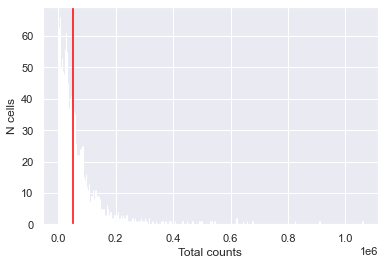

In [14]:
plt.hist(cell_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(50000, color='red')

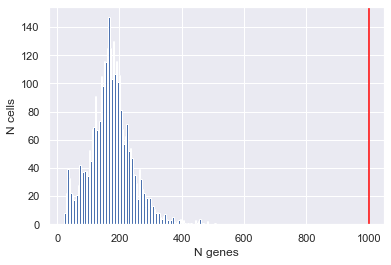

In [15]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(1000, color='red')

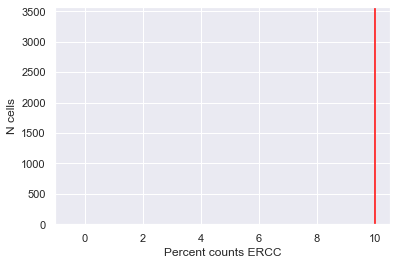

In [16]:
plt.hist(cell_qc_dataframe['pct_counts_ERCC'], bins=1000)
plt.xlabel('Percent counts ERCC')
plt.ylabel('N cells')
plt.axvline(10, color='red')

In [17]:
low_ERCC_mask = (cell_qc_dataframe['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]

In [22]:
# print('Started with: \n', adata)
# sc.pp.filter_cells(adata, min_genes = 750)
# print('Finished with: \n', adata)

Trying to set attribute `.obs` of view, copying.


Started with: 
 View of AnnData object with n_obs × n_vars = 3401 × 935
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'
Finished with: 
 AnnData object with n_obs × n_vars = 0 × 935
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'


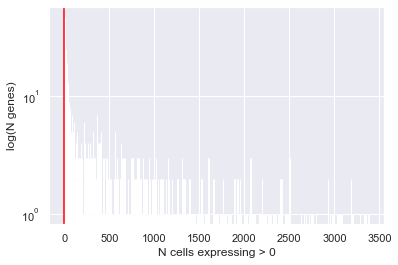

In [21]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') # for visual clarity
plt.axvline(2, color='red')
plt.yscale('log') 

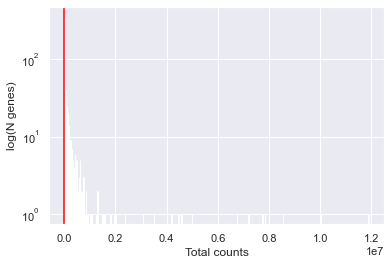

In [20]:
plt.hist(gene_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('log(N genes)') # for visual clarity
plt.yscale('log') 
plt.axvline(10, color='red')

In [22]:
print('Started with: \n', adata)
sc.pp.filter_genes(adata, min_cells = 2)
sc.pp.filter_genes(adata, min_counts = 10)
print('Finished with: \n', adata)

Started with: 
 AnnData object with n_obs × n_vars = 3210 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'
Finished with: 
 AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC', 'n_cells', 'n_counts'


In [22]:
adata.write('data/brain_qc_cilia.h5ad')

In [23]:
?sc.pl.pca_overview

In [24]:
adata_cpm = adata.copy() # apply this to a copy so we can compare methods
adata_cpm.raw = adata_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_cpm, 
                         counts_per_cell_after=1e6)

In [25]:
sc.pp.pca(adata)
#

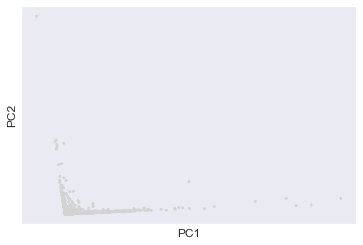

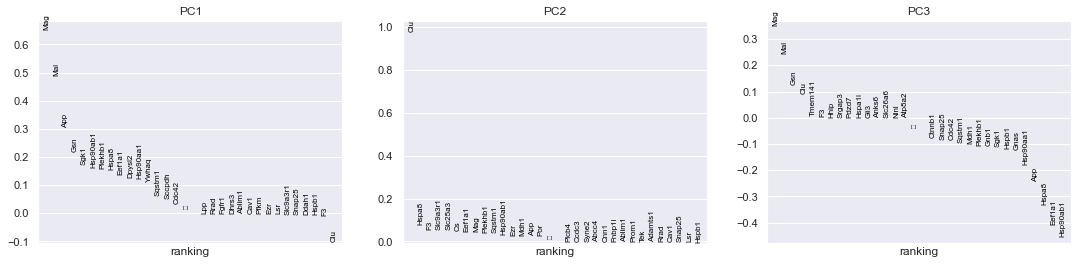

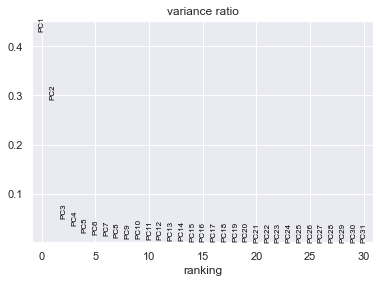

In [27]:
sc.pl.pca_overview(adata)

In [28]:
data_cpm = adata.copy() # apply this to a copy so we can compare methods
adata_cpm.raw = adata_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_cpm, 
                         counts_per_cell_after=1e6)

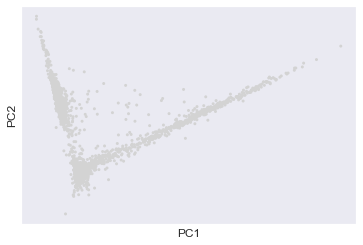

C:\Users\nathendel\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\nathendel\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


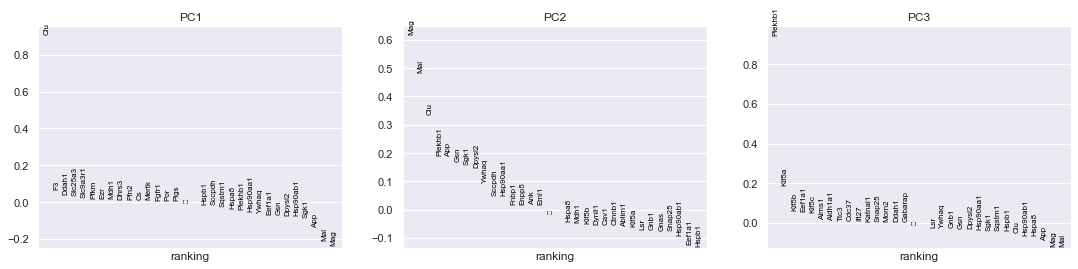

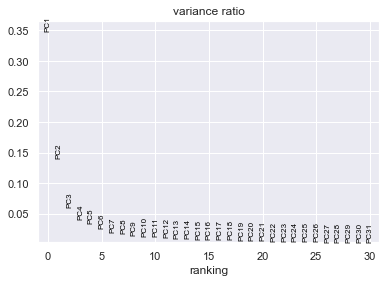

In [29]:
sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm)

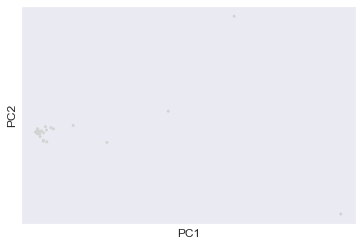

C:\Users\nathendel\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\nathendel\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


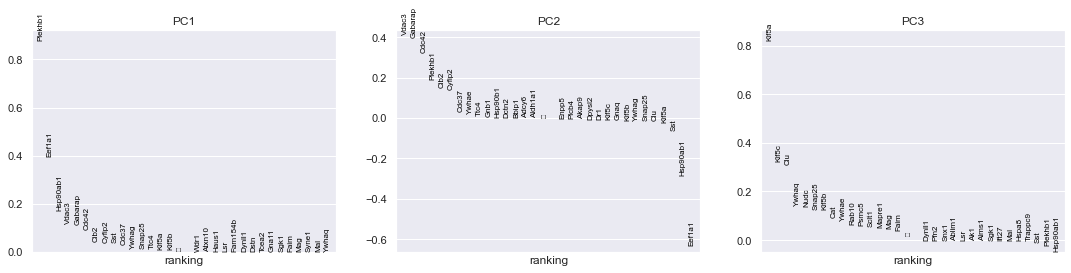

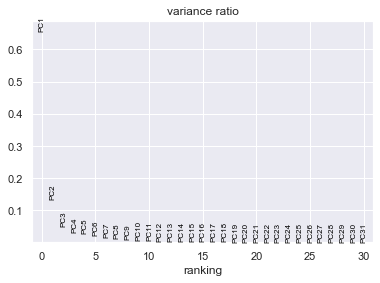

In [30]:
adata_cpm_ex = adata.copy() # make a copy so we can compare results
sc.pp.normalize_total(adata_cpm_ex, target_sum=1e6, exclude_highly_expressed=True) # normalize
sc.pp.pca(adata_cpm_ex) # run pca
sc.pl.pca_overview(adata_cpm_ex) # plot pca

In [31]:
not_Rn45s = adata_cpm.var.index != 'Rn45s'
adata_no_Rn45s = adata_cpm[:, not_Rn45s]

sc.pp.pca(adata_no_Rn45s)
# sc.pl.pca_overview(adata_no_Rn45s, color='mouse.id')

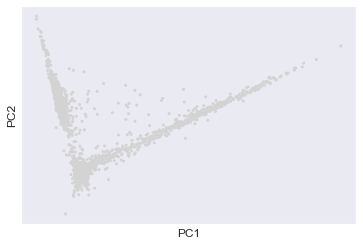

C:\Users\nathendel\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\nathendel\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


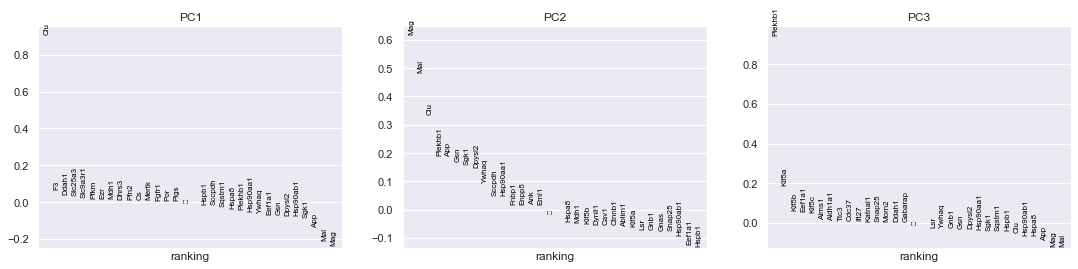

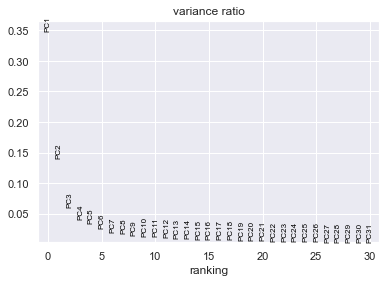

In [32]:
sc.pl.pca_overview(adata_no_Rn45s)

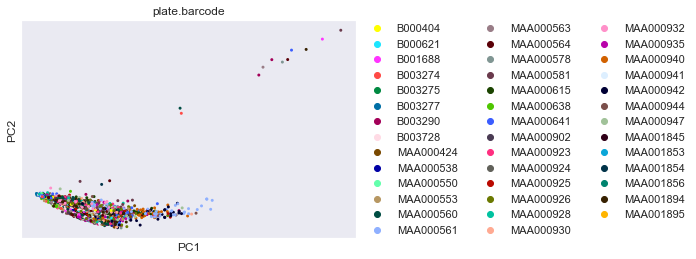

C:\Users\nathendel\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\nathendel\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


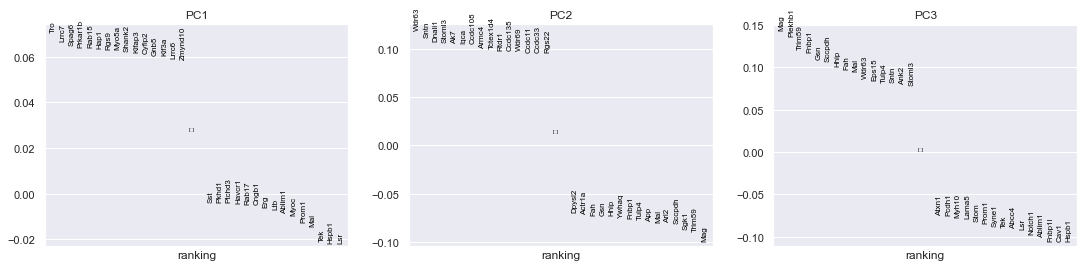

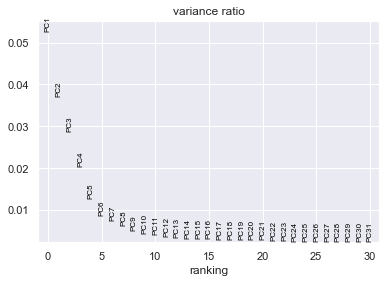

In [33]:
sc.pp.log1p(adata_cpm)
sc.pp.scale(adata_cpm)

sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='plate.barcode')

In [34]:
adata

AnnData object with n_obs × n_vars = 3401 × 935
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [35]:
adata_cpm.write('data/brain_normalized.h5ad')

In [36]:
adata = sc.read('data/brain_normalized.h5ad')

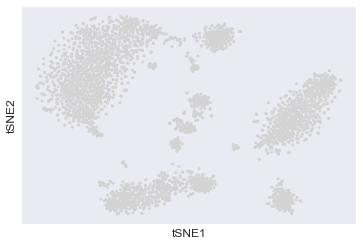

In [37]:
sc.tl.tsne(adata, perplexity=30, learning_rate=1000, random_state=0)

sc.pl.tsne(adata)

In [38]:
sc.pp.neighbors(adata) # UMAP is based on the neighbor graph; we'll compute this first
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)

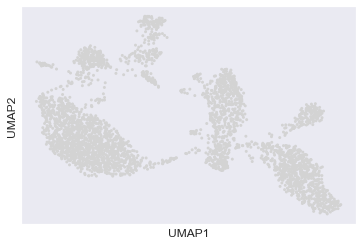

In [39]:
sc.pl.umap(adata)

In [ ]:
None in adata.obs.cell_ontology_class